In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import PIL
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2

%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

random_state = 22222

In [2]:
# Test to see whether you have all necessary libraries for GPU support
# If so, this should output a list with at least one GPU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
!ls data

happy-whale-and-dolphin  local_split  random_image


In [5]:
!ls data/happy-whale-and-dolphin/

sample_submission.csv  test_images  train.csv  train_images


In [6]:
full_train_df = pd.read_csv('data/happy-whale-and-dolphin/train.csv')

full_train_df

image               species individual_id
0      00021adfb725ed.jpg    melon_headed_whale  cadddb1636b9
1      000562241d384d.jpg        humpback_whale  1a71fbb72250
2      0007c33415ce37.jpg    false_killer_whale  60008f293a2b
3      0007d9bca26a99.jpg    bottlenose_dolphin  4b00fe572063
4      00087baf5cef7a.jpg        humpback_whale  8e5253662392
...                   ...                   ...           ...
51028  fff639a7a78b3f.jpg                beluga  5ac053677ed1
51029  fff8b32daff17e.jpg  cuviers_beaked_whale  1184686361b3
51030  fff94675cc1aef.jpg            blue_whale  5401612696b9
51031  fffbc5dd642d8c.jpg                beluga  4000b3d7c24e
51032  fffdcd42312777.jpg    bottlenose_dolphin  4ddb2eeb5efb

[51033 rows x 3 columns]

In [7]:
full_train_df['species'].value_counts()

bottlenose_dolphin           9664
beluga                       7443
humpback_whale               7392
blue_whale                   4830
false_killer_whale           3326
dusky_dolphin                3139
spinner_dolphin              1700
melon_headed_whale           1689
minke_whale                  1608
killer_whale                 1493
fin_whale                    1324
gray_whale                   1123
bottlenose_dolpin            1117
kiler_whale                   962
southern_right_whale          866
spotted_dolphin               490
sei_whale                     428
short_finned_pilot_whale      367
common_dolphin                347
cuviers_beaked_whale          341
pilot_whale                   262
long_finned_pilot_whale       238
white_sided_dolphin           229
brydes_whale                  154
pantropic_spotted_dolphin     145
globis                        116
commersons_dolphin             90
pygmy_killer_whale             76
rough_toothed_dolphin          60
frasiers_dolph

Some of the species names are incorrect (e.g. "kiler_whale") and one set of species are so similar that there is more variation within each species than between species (e.g. "globis", "short_finned_pilot_whale", and "long_finned_pilot_whale"), so we'll fix that here.

In [8]:
full_train_df['species'].replace({"globis": "pilot_whale",
                          "short_finned_pilot_whale": "pilot_whale",
                          "long_finned_pilot_whale": "pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

full_train_df['species'].value_counts()

bottlenose_dolphin           10781
beluga                        7443
humpback_whale                7392
blue_whale                    4830
false_killer_whale            3326
dusky_dolphin                 3139
killer_whale                  2455
spinner_dolphin               1700
melon_headed_whale            1689
minke_whale                   1608
fin_whale                     1324
gray_whale                    1123
pilot_whale                    983
southern_right_whale           866
spotted_dolphin                490
sei_whale                      428
common_dolphin                 347
cuviers_beaked_whale           341
white_sided_dolphin            229
brydes_whale                   154
pantropic_spotted_dolphin      145
commersons_dolphin              90
pygmy_killer_whale              76
rough_toothed_dolphin           60
frasiers_dolphin                14
Name: species, dtype: int64

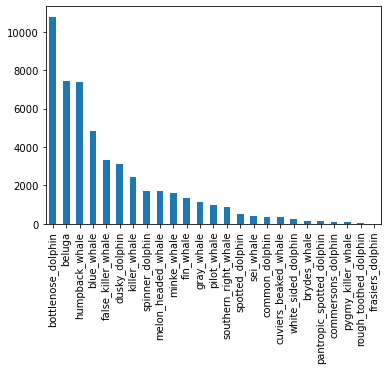

In [9]:
full_train_df['species'].value_counts().plot.bar();

# Exploring the images

In [10]:
kaggle_data_dir = 'data/happy-whale-and-dolphin/train_images'

In [11]:
species_list = list(set(full_train_df['species'].values))
species_list.sort()

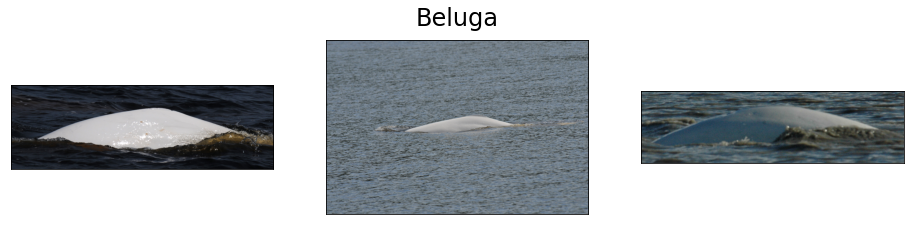

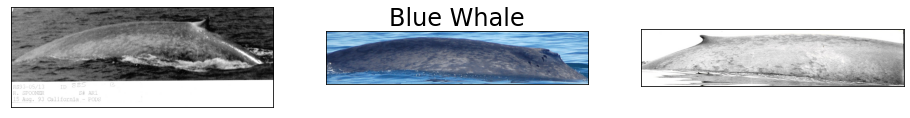

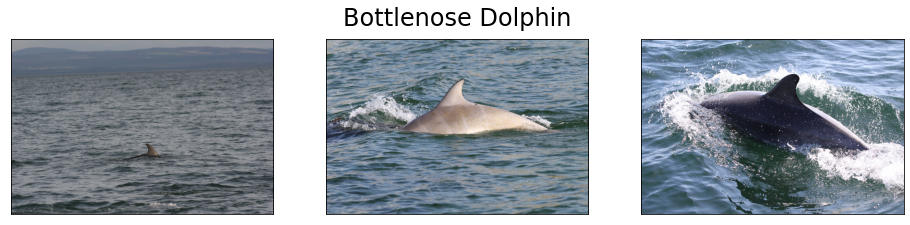

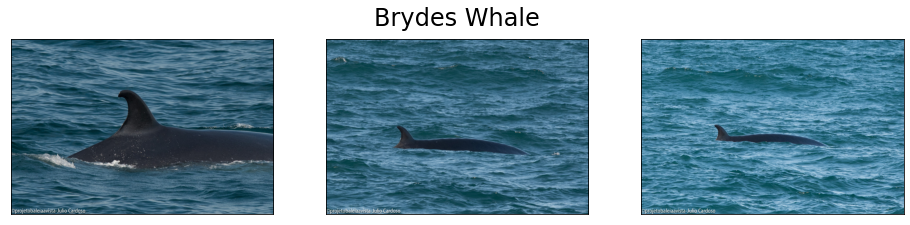

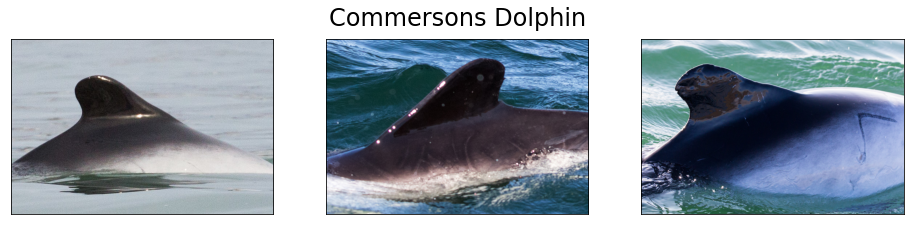

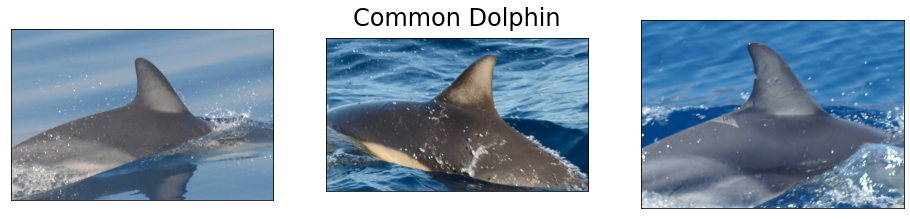

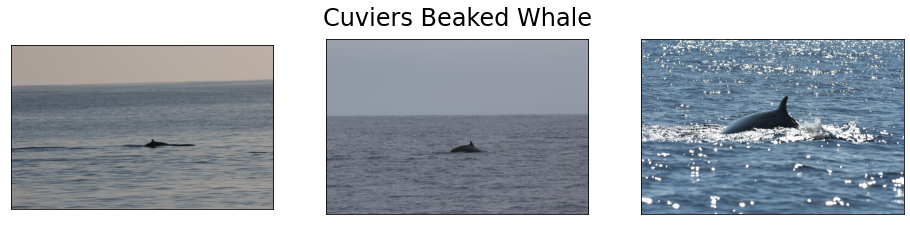

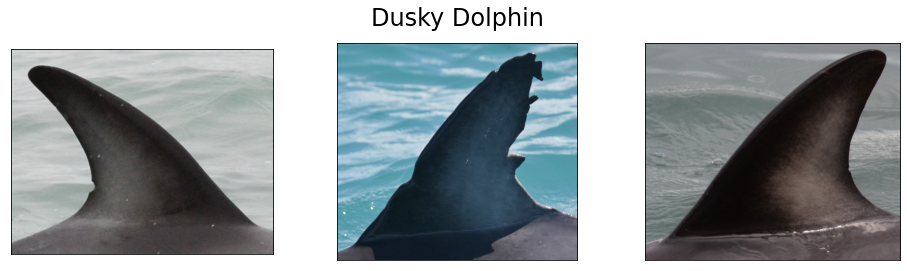

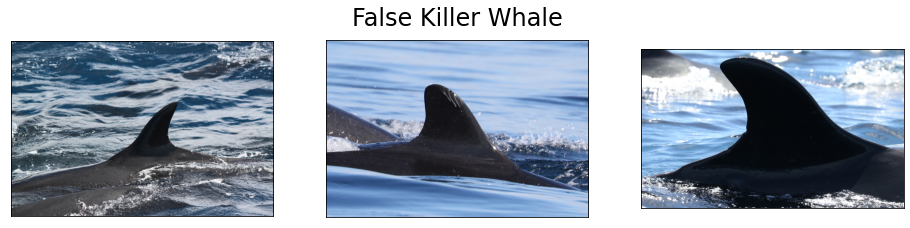

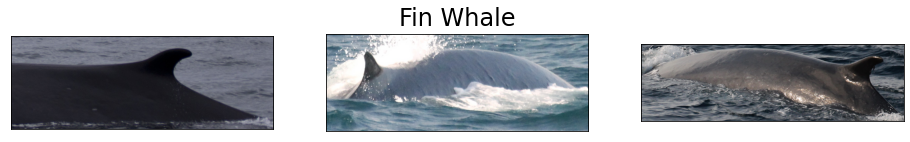

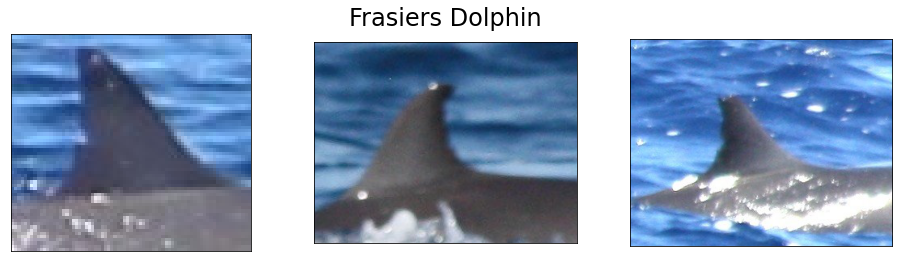

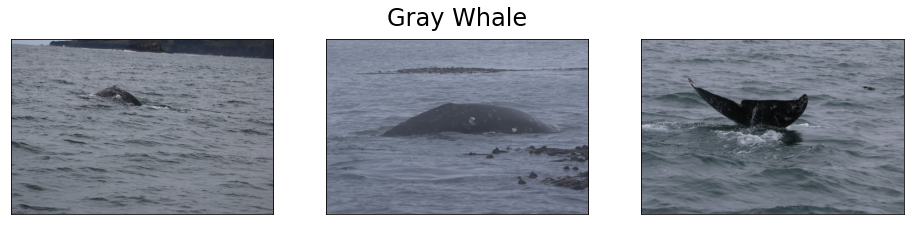

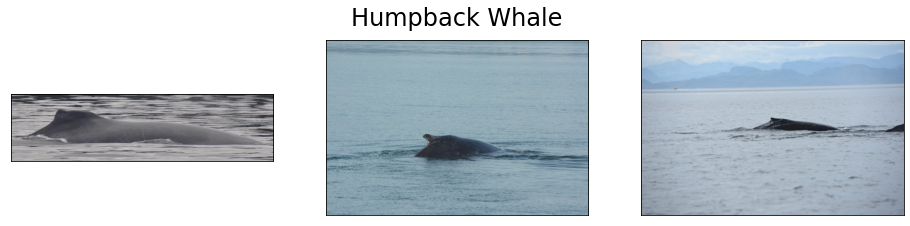

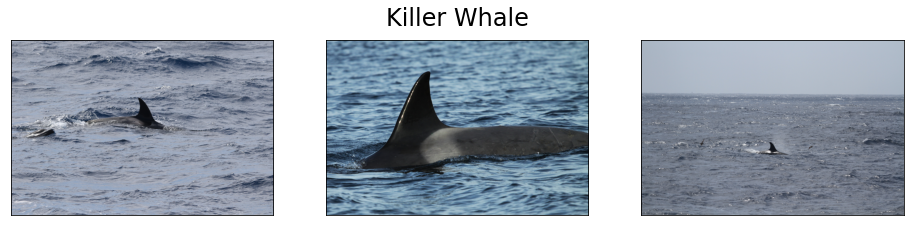

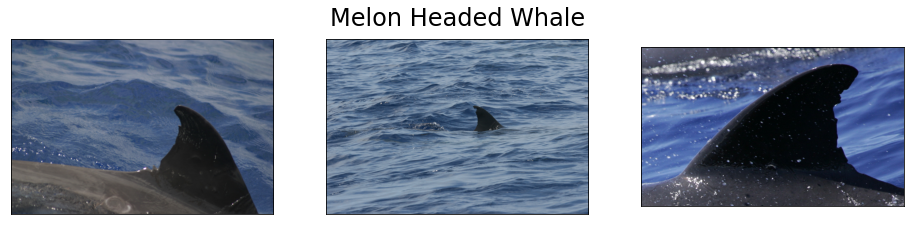

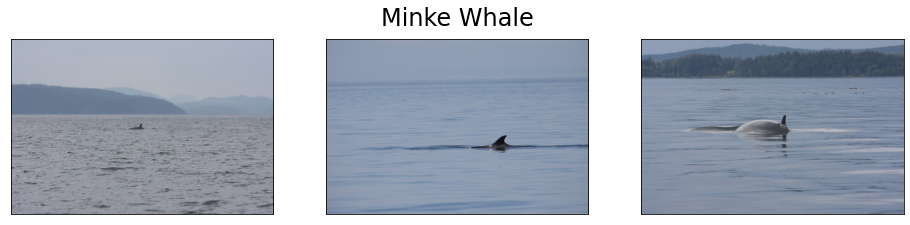

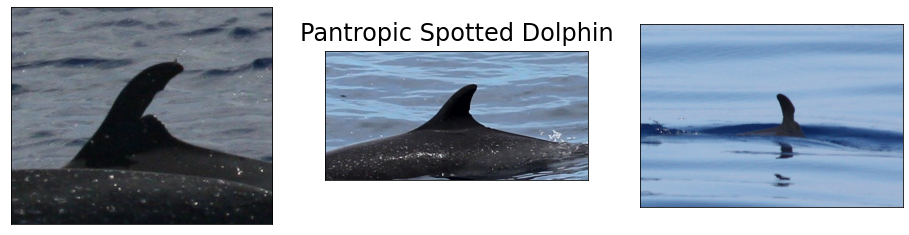

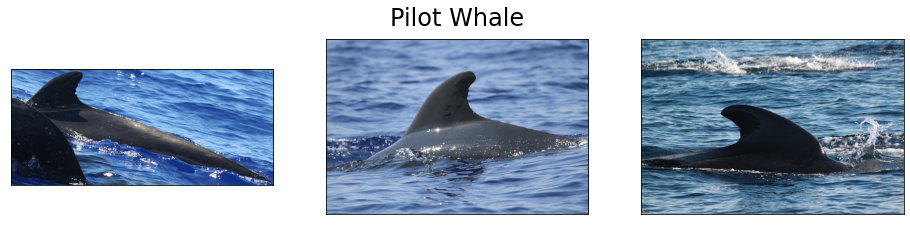

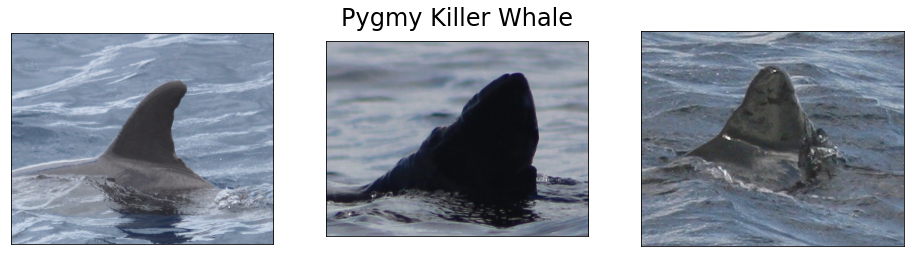

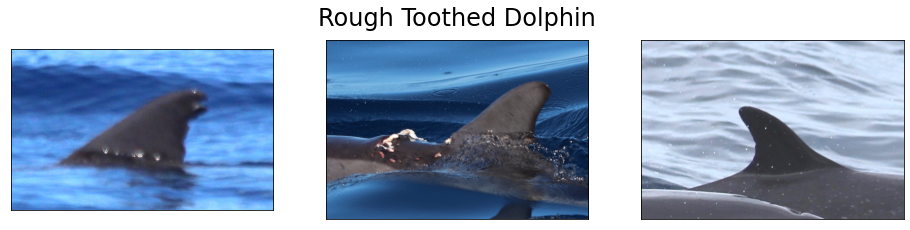

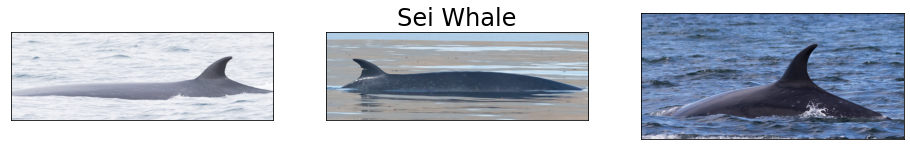

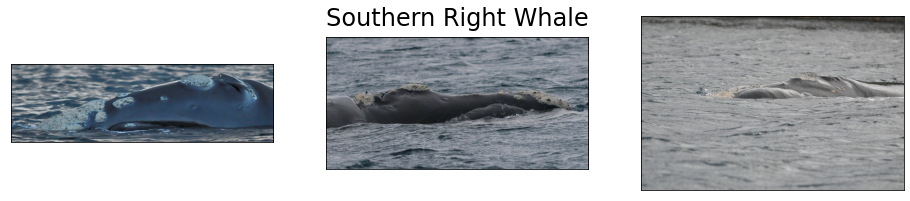

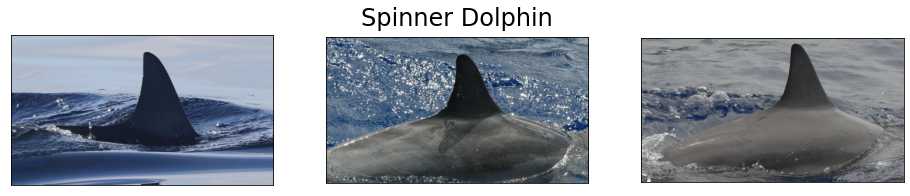

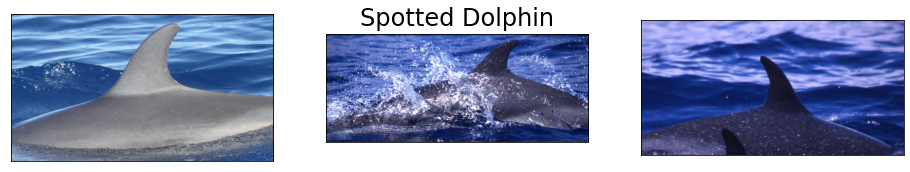

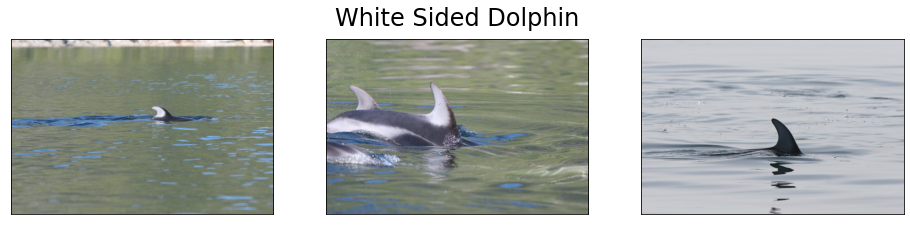

In [30]:
for species in species_list:
    temp_species_df = full_train_df[full_train_df['species'] == species]
    i_list = np.random.choice(list(range(len(temp_species_df))), 3, False)
    temp_specimens_df = pd.DataFrame(temp_species_df.iloc[i_list[0],:]).T.append(temp_species_df.iloc[i_list[1],:]).append(temp_species_df.iloc[i_list[2],:])
    rand_spec_img1 = PIL.Image.open(os.path.join(kaggle_data_dir, temp_specimens_df['image'].values[0]))
    rand_spec_img2 = PIL.Image.open(os.path.join(kaggle_data_dir, temp_specimens_df['image'].values[1]))
    rand_spec_img3 = PIL.Image.open(os.path.join(kaggle_data_dir, temp_specimens_df['image'].values[2]))
    
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16,4), ncols=3)

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(rand_spec_img1)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.imshow(rand_spec_img2)
    plt.text(0.5, 1.08, ' '.join(species.split('_')).title(),
         horizontalalignment='center',
         fontsize=24,
         transform = ax2.transAxes)

    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.imshow(rand_spec_img3);

# The train/val/test split

We'll do two sets of splits, one to create a dataset for training species recognition, and one for training individual recognition. The reason for this is that the necessary sizes of the val and test sets in the individual id recognition set are larger than we would ideally like them to be. This is because making sure that each individual ends up in the train set AND that the split is stratified requires about 6,000 photos in val and test, far more than is necessary. So the species split will be a more ideal 95/5 split, and the id split will be its own irregular thing.

### The species split is fairly straightforward.

In [12]:
train_val_df_sp, test_df_sp = train_test_split(full_train_df, test_size=.05, stratify=full_train_df['species'], random_state=random_state)

In [13]:
train_df_sp, val_df_sp = train_test_split(train_val_df_sp, test_size=.05, stratify=train_val_df_sp['species'], random_state=random_state)

### The individual id split is slightly more complicated.

There are some individuals for whom only one image exists. We want to make sure they end up in the train set because if we eventually submit our work to the Kaggle competition, we'll want to have trained on them. Unfortunately, merely setting stratify inside train_test_split won't work, because there would need to be at least two images, so first, we'll move those individuals to a special dataframe that we eventually merge with our train dataframe.

In [14]:
# Pull out the individuals for whom only one image exists and put them in their own dataframe
counts = full_train_df['individual_id'].value_counts()

single_ind_df = full_train_df[full_train_df['individual_id'].isin(counts[counts == 1].index)]
partial_full_df = full_train_df[~full_train_df['individual_id'].isin(counts[counts == 1].index)]

In [15]:
single_ind_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9258 entries, 0 to 51018
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          9258 non-null   object
 1   species        9258 non-null   object
 2   individual_id  9258 non-null   object
dtypes: object(3)
memory usage: 289.3+ KB


In [16]:
partial_full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41775 entries, 1 to 51032
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   image          41775 non-null  object
 1   species        41775 non-null  object
 2   individual_id  41775 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [17]:
# Split on the remaining dataframe
train_val_df_id, test_df_id = train_test_split(partial_full_df, test_size=.152, stratify=partial_full_df['individual_id'], random_state=random_state)

In [18]:
train_df_id_lite, val_df_id = train_test_split(train_val_df_id, test_size=.179, stratify=train_val_df_id['individual_id'], random_state=random_state)

In [19]:
# Combine into one dataframe the unique individuals and the train group made above
train_df_id = pd.concat([single_ind_df, train_df_id_lite]).sort_index()

In [20]:
train_df_id.head()

image             species individual_id
0  00021adfb725ed.jpg  melon_headed_whale  cadddb1636b9
1  000562241d384d.jpg      humpback_whale  1a71fbb72250
2  0007c33415ce37.jpg  false_killer_whale  60008f293a2b
3  0007d9bca26a99.jpg  bottlenose_dolphin  4b00fe572063
4  00087baf5cef7a.jpg      humpback_whale  8e5253662392

In [21]:
# Just to make sure we've done everything right
(pd.concat([train_df_id, val_df_id, test_df_id]).sort_index() == full_train_df).value_counts()

image  species  individual_id
True   True     True             51033
dtype: int64

### Organizing our data

We'll create a directory structure for our data so that we can benefit from common dataset preparation functions and methods (if we didn't, we'd have to use flow_from_dataframe on an ImageDataGenerator object, which has a few downsides further down the line; much more convenient to use image_dataset_from_directory, assuming we have the space, which we do).

In [22]:
local_dataset_imgs_names = [file for file in os.listdir(kaggle_data_dir)]
local_dataset_imgs_names[0:10]

['00021adfb725ed.jpg',
 '000562241d384d.jpg',
 '0007c33415ce37.jpg',
 '0007d9bca26a99.jpg',
 '00087baf5cef7a.jpg',
 '000a8f2d5c316a.jpg',
 '000be9acf46619.jpg',
 '000bef247c7a42.jpg',
 '000c3d63069748.jpg',
 '000c476c11bad5.jpg']

In [23]:
print('There are', len(local_dataset_imgs_names), 'whale and dolphin images to be split.')

There are 51033 whale and dolphin images to be split.


In [24]:
# Create directory structure paths

local_split_dir = 'data/local_split'

sp_dir = os.path.join(local_split_dir, 'sp')
id_dir = os.path.join(local_split_dir, 'id')

train_folder_sp = os.path.join(sp_dir, 'train')
val_folder_sp = os.path.join(sp_dir, 'validation')
test_folder_sp = os.path.join(sp_dir, 'test')

train_folder_id = os.path.join(id_dir, 'train')
val_folder_id = os.path.join(id_dir, 'validation')
test_folder_id = os.path.join(id_dir, 'test')

Only run the two cells below once during initial setup.

In [25]:
# # Create directories at those paths

# os.mkdir(local_split_dir)

# os.mkdir(sp_dir)
# os.mkdir(id_dir)

# os.mkdir(train_folder_sp)
# os.mkdir(val_folder_sp)
# os.mkdir(test_folder_sp)

# os.mkdir(train_folder_id)
# os.mkdir(val_folder_id)
# os.mkdir(test_folder_id)

In [26]:
# # Make subfolders for each class

# for class_name in full_train_df['species'].unique():
#     for folder in ['train', 'validation', 'test']:
#         os.mkdir(os.path.join('data/local_split/sp', folder, class_name))
    
# for class_name in full_train_df['individual_id'].unique():
#     for folder in ['train', 'validation', 'test']:
#         os.mkdir(os.path.join('data/local_split/id', folder, class_name))

In [27]:
img_dfs = [train_df_sp, val_df_sp, test_df_sp, train_df_id, val_df_id, test_df_id]
img_names_prezip = [list(df['image'].values) for df in img_dfs]
img_names = list(zip([('sp', 'train'), ('sp', 'validation'), ('sp', 'test'), ('id', 'train'), ('id', 'validation'), ('id', 'test')], img_names_prezip))

Now we'll copy the images from kaggle's train folder into our new folder structure, according to the train/val/test split we just performed on the dataframe.

Only run this cell during initial setup.

In [28]:
# for folders, img_list in img_names:
#     for image in img_list:
#         if folders[0] == 'sp':
#             class_name = full_train_df[full_train_df['image'] == image]['species'].values[0]
#         elif folders[0] == 'id':
#             class_name = full_train_df[full_train_df['image'] == image]['individual_id'].values[0]
#         origin = os.path.join(kaggle_data_dir, image)
#         destination = os.path.join('data/local_split', folders[0], folders[1], class_name, image)
#         shutil.copyfile(origin, destination)

And we'll run a loop to check for corrupted images. We can then re-import the    corrupt ones.

In [29]:
def return_corrupt():

    import filecmp

    global bads
    bads = []

    for folder in os.listdir('data/local_split'):
        for subfolder in os.listdir(os.path.join('data/local_split', folder)):
            for subsubfolder in os.listdir(os.path.join('data/local_split', folder, subfolder)):
                for image in os.listdir(os.path.join('data/local_split', folder, subfolder, subsubfolder)):
                    origin = os.path.join('data/happy-whale-and-dolphin/train_images', image)
                    destination = os.path.join('data/local_split', folder, subfolder, subsubfolder, image)
                    try:
                        if not filecmp.cmp(origin, destination):
                            bads.append((folder, subfolder, subsubfolder, image))
                    except:
                        bads.append((folder, subfolder, subsubfolder, image))
    return bads

In [30]:
def recheck_bads():

    import filecmp

    global bads
    global bads_recheck
    
    bads_recheck = []

    for image_path in bads:
        origin = os.path.join('data/happy-whale-and-dolphin/train_images', image_path[3])
        destination = os.path.join('data/local_split', image_path[0], image_path[1], image_path[2], image_path[3])
        try:
            if not filecmp.cmp(origin, destination):
                bads_recheck.append((folder, subfolder, subsubfolder, image))
        except:
            bads_recheck.append((folder, subfolder, subsubfolder, image))
    
    return bads_recheck

The next three cells should only need to be run on first unpacking the dataset.

In [31]:
# return_corrupt()

In [32]:
# for image_path in bads:
#         origin = os.path.join('data/happy-whale-and-dolphin/train_images', image_path[3])
#         destination = os.path.join('data/local_split', image_path[0], image_path[1], image_path[2], image_path[3])
#         shutil.copyfile(origin, destination)

In [33]:
# recheck_bads()

# Preparing our data

We'll reduce our image sizes and apply some data augmentation. 

In [37]:
image_size = (128, 128)
batch_size = 32

train_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder_sp,
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,
)

val_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    val_folder_sp,
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,
)

test_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder_sp,
    color_mode='grayscale',
    image_size=image_size,
    batch_size=batch_size,
)

Found 46056 files belonging to 25 classes.
Found 2425 files belonging to 25 classes.
Found 2552 files belonging to 25 classes.


In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_sp = train_ds_sp.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_sp = val_ds_sp.cache().prefetch(buffer_size=AUTOTUNE)

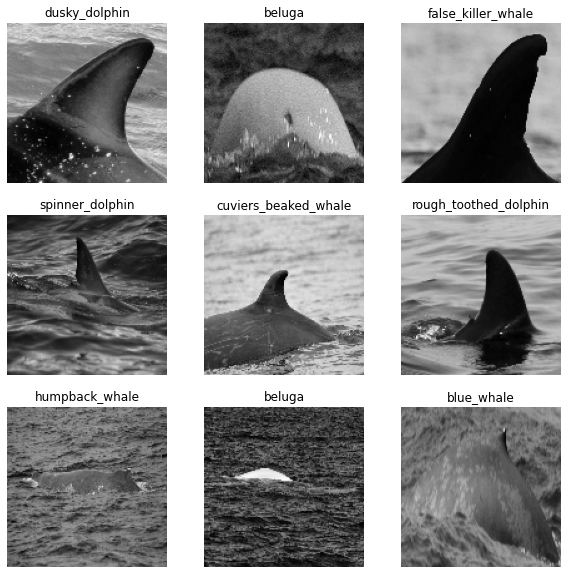

In [57]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_sp.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy(), cmap='gray')
        plt.title(species_list[labels[i]])
        plt.axis("off")

# Setting up a model

In [39]:
filepath = 'models/best_model_cnn2.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=5)

callbacks = [checkpoint, reduce_lr, early_stopping]

In [40]:
cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn2.add(layers.Dense(25, activation='softmax'))

adam = Adam(learning_rate=.001)
cnn2.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
cnn2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       1

In [44]:
history_cnn2 = cnn2.fit(train_ds_sp,
                    epochs=20,
                    validation_data=val_ds_sp,
                    callbacks=callbacks)

Epoch 1/20
1440/1440 [==============================] - 24s 17ms/step - loss: 1.0219 - accuracy: 0.7578 - val_loss: 1.1366 - val_accuracy: 0.7315

Epoch 00001: val_loss did not improve from 1.12141
Epoch 2/20
1440/1440 [==============================] - 24s 17ms/step - loss: 1.0200 - accuracy: 0.7590 - val_loss: 1.1824 - val_accuracy: 0.7208

Epoch 00002: val_loss did not improve from 1.12141
Epoch 3/20
1440/1440 [==============================] - 24s 17ms/step - loss: 1.0106 - accuracy: 0.7618 - val_loss: 1.1569 - val_accuracy: 0.7381

Epoch 00003: val_loss did not improve from 1.12141
Epoch 4/20
1440/1440 [==============================] - 24s 17ms/step - loss: 1.0052 - accuracy: 0.7655 - val_loss: 1.1380 - val_accuracy: 0.7439

Epoch 00004: val_loss did not improve from 1.12141
Epoch 5/20
1440/1440 [==============================] - 24s 17ms/step - loss: 0.9963 - accuracy: 0.7647 - val_loss: 1.1365 - val_accuracy: 0.7377

Epoch 00005: val_loss did not improve from 1.12141
Epoch 6/20

In [42]:
load_file = 'models/best_model_cnn2.hdf5'

In [43]:
best_model_cnn2 = load_model(load_file)

In [44]:
best_model_cnn2.evaluate(test_ds_sp)

80/80 [==============================] - 22s 187ms/step - loss: 1.1228 - accuracy: 0.7394


[1.1228264570236206, 0.7394200563430786]

# Making and visualizing random predictions

In [45]:
def random_prediction(model):
    
    random_image_dir = 'data/random_image'
    if 'random_image' not in os.listdir('data'):
        os.mkdir(random_image_dir)
    else:
        pass    

    for class_name in full_train_df['species'].unique():
            if class_name not in os.listdir(random_image_dir):
                os.mkdir(os.path.join(random_image_dir, class_name))    

    for folder in os.listdir(random_image_dir):
        for item in os.listdir(os.path.join(random_image_dir, folder)):
            os.remove(os.path.join(random_image_dir, folder, item))    

    i = np.random.randint(0, len(test_df_sp))
    random_image_df = pd.DataFrame(test_df_sp.iloc[i,:]).T

    actual_class = random_image_df['species'].values[0]
    origin = os.path.join(kaggle_data_dir, random_image_df['image'].values[0])
    destination = os.path.join(random_image_dir, actual_class, random_image_df['image'].values[0])
    shutil.copyfile(origin, destination)
    
    random_image_ds = tf.keras.preprocessing.image_dataset_from_directory(random_image_dir,
                                                                          color_mode='grayscale',
                                                                          image_size=(128, 128),
                                                                          batch_size=1,
                                                                          )    

    random_image_pred = model.predict(random_image_ds)
    random_image_class = random_image_df.values[0][1]
    random_image_class_index = species_list.index(random_image_class)
    
    random_image = os.path.join(kaggle_data_dir, random_image_df.values[0][0])
    random_image_pil = PIL.Image.open(random_image)
    
    rand_img_pred_list = list(random_image_pred[0])
    rand_img_class_pred_index = np.where(random_image_pred == np.amax(random_image_pred))[1][0]
    rand_img_class_pred = species_list[rand_img_class_pred_index]
   
    if rand_img_class_pred != random_image_class:
        colors = ['red' if i == random_image_class_index else 'gray' for i in range(0, 25)]
    else:
        colors = ['C0' if i == random_image_class_index else 'gray' for i in range(0, 25)]
        
    class_ratio = int(round(train_df_sp['species'].value_counts().loc[random_image_class]/len(train_df_sp)*100))
    print(f'{random_image_class} makes up ca. {class_ratio}% of the training dataset.')

    fig, (ax1, ax2)= plt.subplots(figsize=(16,6), ncols=2)

    ax1.grid(False)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(random_image_pil)
    ax1.set_title(f'Actual class: {random_image_class}')

    ax2.bar(range(len(random_image_pred[0])), list(random_image_pred[0]), color=colors)
    ax2.set_xlim(-1, 25)
    ax2.set_xticks(range(0, 25))
    ax2.set_xticklabels(species_list)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, horizontalalignment='center')
    ax2.set_title(f'Predicted Class: {rand_img_class_pred}');

Found 1 files belonging to 25 classes.
humpback_whale makes up ca. 14% of the training dataset.


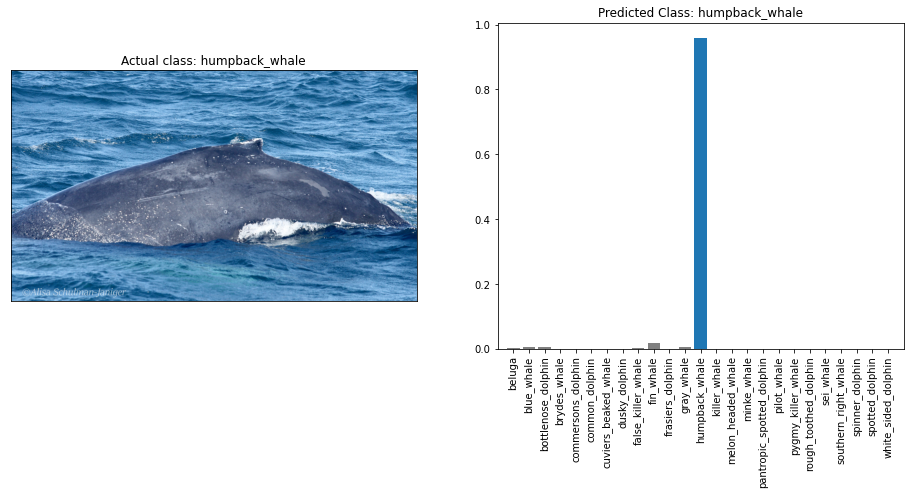

In [536]:
random_prediction(best_model_cnn2)

# Advanced Models with Transfer Learning

### Adjusting the input

In [46]:
image_size = (64, 64)
batch_size = 32

train_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    train_folder_sp,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    val_folder_sp,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds_sp = tf.keras.preprocessing.image_dataset_from_directory(
    test_folder_sp,
    image_size=image_size,
    batch_size=batch_size,
)

Found 46056 files belonging to 25 classes.
Found 2425 files belonging to 25 classes.
Found 2552 files belonging to 25 classes.


In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_sp = train_ds_sp.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_sp = val_ds_sp.cache().prefetch(buffer_size=AUTOTUNE)

### Setting up a model

In [48]:
filepath = 'models/best_model_cnn3.hdf5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=5)

callbacks = [checkpoint, reduce_lr, early_stopping]

In [49]:
cnn3 = models.Sequential()
cnn3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
cnn3.add(layers.MaxPooling2D((2, 2)))
cnn3.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn3.add(layers.MaxPooling2D((2, 2)))
cnn3.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn3.add(layers.MaxPooling2D((2, 2)))
cnn3.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn3.add(layers.MaxPooling2D((2, 2)))
cnn3.add(layers.Flatten())
cnn3.add(layers.Dense(256, activation='relu', kernel_regularizer=l2(l2=0.005)))
cnn3.add(layers.Dense(25, activation='softmax'))

adam = Adam(learning_rate=.001)
cnn3.compile(optimizer=adam,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
cnn3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 128)      

In [ ]:
history_cnn3 = cnn3.fit(train_ds_sp,
                    epochs=30,
                    validation_data=val_ds_sp,
                    callbacks=callbacks)

Epoch 1/30
 739/1440 [==============>...............] - ETA: 2:53 - loss: 3.5086 - accuracy: 0.5508

In [51]:
load_file = 'models/best_model_cnn3.hdf5'

In [52]:
best_model_cnn3 = load_model(load_file)

In [53]:
best_model_cnn3.evaluate(test_ds_sp)

80/80 [==============================] - 15s 171ms/step - loss: 0.9760 - accuracy: 0.7806


[0.9760068655014038, 0.7805642485618591]

In [38]:
#128x128, grayscale

80/80 [==============================] - 23s 190ms/step - loss: 1.1228 - accuracy: 0.7394


[1.1228266954421997, 0.7394200563430786]

In [51]:
#64x64, grayscale

80/80 [==============================] - 17s 185ms/step - loss: 1.1345 - accuracy: 0.7226


[1.1344735622406006, 0.722570538520813]

In [60]:
#64x64, rgb

80/80 [==============================] - 19s 209ms/step - loss: 0.9760 - accuracy: 0.7806


[0.9760069847106934, 0.7805642485618591]